#                           Sentiment Analysis of Yelp Reviews

In [61]:
import pandas as pd # For data manupulation
import matplotlib.pyplot as plt # For visualizations
import seaborn as sns # For visualization
import re # Regular Expressions (tokenization)
import string # For string manipulation (Remove punctuation)

import nltk
from nltk.corpus import stopwords

### Importing the dataset

In [62]:
#importing the data using pandas
yelp_data = pd.read_csv('yelp.csv')

In [63]:
yelp_data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [64]:
#created a new variable called length to find out length of the review
yelp_data['text_length'] = yelp_data['text'].apply(len)
yelp_data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


In [65]:
yelp_data.shape

(10000, 11)

### Exploring the dataset

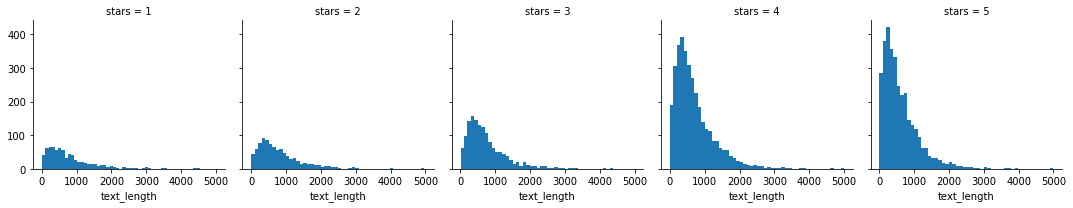

In [66]:
#to check relation between length of the review and star rating
g = sns.FacetGrid(data=yelp_data, col='stars')
g.map(plt.hist, 'text_length', bins=50)

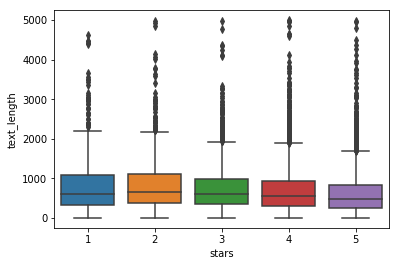

In [67]:
#boxplot to look for outliers
sns.boxplot(x='stars', y='text_length', data = yelp_data)

Range of the text_length is 0-5000. It is skewed towards right.
There are lot of ouliers as anything outside the whiskers is termed as outlier

In [68]:
# To determine correlation between text_length and stars
stars = yelp_data.groupby('stars').mean()
stars.corr()

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


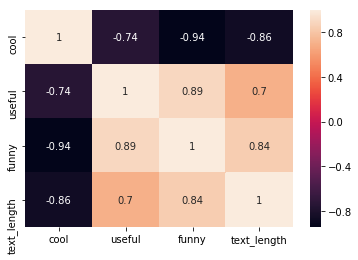

In [69]:
sns.heatmap(data=stars.corr(), annot = True)

In [70]:
# We use only reviews with rating 1 and rating 5 to predict good or bad reviews
yelp_class = yelp_data[(yelp_data['stars']==1)|(yelp_data['stars']==5)]
yelp_class.head()   

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


In [71]:
yelp_class.shape

(4086, 11)

In [72]:
# Defining dependant and independant variables
X = yelp_class['text']
y = yelp_class['stars']

In [73]:
X[0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

### Cleaning the dataset

In [74]:
#nopunc = [char for char in X if char not in string.punctuation]
#nopunc = ''.join(nopunc)
#nopunc_lower = nopunc.lower()
#nopunc_stopwords = [w for w in nopunc_lower if w not in stopwords.words('english')]

In [75]:
def clean_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [76]:
clean_text(X)

['wife',
 'took',
 'birthday',
 'breakfast',
 'excellent.',
 'weather',
 'perfect',
 'made',
 'sitting',
 'outside',
 'overlooking',
 'grounds',
 'absolute',
 'pleasure.',
 'waitress',
 'excellent',
 'food',
 'arrived',
 'quickly',
 'semi-busy',
 'Saturday',
 'morning.',
 'looked',
 'like',
 'place',
 'fills',
 'pretty',
 'quickly',
 'earlier',
 'get',
 'better.',
 'favor',
 'get',
 'Bloody',
 'Mary.',
 'phenomenal',
 'simply',
 'best',
 "I've",
 'ever',
 'had.',
 "I'm",
 'pretty',
 'sure',
 'use',
 'ingredients',
 'garden',
 'blend',
 'fresh',
 'order',
 'it.',
 'amazing.',
 'EVERYTHING',
 'menu',
 'looks',
 'excellent,',
 'white',
 'truffle',
 'scrambled',
 'eggs',
 'vegetable',
 'skillet',
 'tasty',
 'delicious.',
 'came',
 '2',
 'pieces',
 'griddled',
 'bread',
 'amazing',
 'absolutely',
 'made',
 'meal',
 'complete.',
 'best',
 '"toast"',
 "I've",
 'ever',
 'had.',
 'Anyway,',
 "can't",
 'wait',
 'go',
 'back!I',
 'idea',
 'people',
 'give',
 'bad',
 'reviews',
 'place.',
 'goes',

### Vectorization
Process of encoding text as integers to create feature vectors (n-dimensional vector of numerical features that represent some object). Raw text needs to be converted to integers so that the ML models can understand.

In [77]:
#In this case we will be using Count Vectorizer to convert the text collection into a matrix of token counts.

from sklearn.feature_extraction.text import CountVectorizer

In [78]:
count_vect = CountVectorizer(analyzer = clean_text)
X_cnt = count_vect.fit(X) # fitting as well as transforming it to a feature vector
X_count = X_cnt.transform(X)
len(count_vect.vocabulary_)

26435

### Training the model 

#### Naive Bayes model

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size = 0.3, random_state = 0) 

In [80]:
# Model 1 - Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb_model = nb.fit(X_train, y_train)

In [81]:
y_predNB = nb.predict(X_test)
y_predNB

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
cm_nb = confusion_matrix(y_test, y_predNB)
report_nb = classification_report(y_test, y_predNB)
print('Results of Naive Bayes model: ')
print(cm_nb, '\n', report_nb)

Results of Naive Bayes model: 
[[129 102]
 [ 31 964]] 
               precision    recall  f1-score   support

           1       0.81      0.56      0.66       231
           5       0.90      0.97      0.94       995

   micro avg       0.89      0.89      0.89      1226
   macro avg       0.86      0.76      0.80      1226
weighted avg       0.89      0.89      0.88      1226



#### Random Forest Model

In [83]:
# Model 2 - Random forest
import numpy as np
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_depth = 50, n_jobs = -1)
rf_model = rf.fit(X_train, y_train)

In [84]:
y_predRF = rf.predict(X_test)

In [85]:
y_predRF

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [86]:
cm_rf = confusion_matrix(y_test, y_predRF)
report_rf = classification_report(y_test, y_predRF)
print('Results of Random Forest model: ')
print(cm_rf, '\n', report_rf)

Results of Random Forest model: 
[[ 30 201]
 [  0 995]] 
               precision    recall  f1-score   support

           1       1.00      0.13      0.23       231
           5       0.83      1.00      0.91       995

   micro avg       0.84      0.84      0.84      1226
   macro avg       0.92      0.56      0.57      1226
weighted avg       0.86      0.84      0.78      1226

